In [1]:
import cv2 
import os 
import glob
import json
import csv
import io
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd


from functools import partial
from p_tqdm import p_map
from tqdm import tqdm 
from module.utils import imread, imfindcircles, findProjectiveTransform, str2array, circle_detection_multi_thread
from module.disp_measure import displacement_measure, homography_transformation, find_valid_dest_circles
from module.apca import run_apca_cas 

# Import circle detection and APCA parameters 
with open('params.json') as param_config_json : 
    param_config = json.load(param_config_json)



In [2]:
'''
1. Check if any images where circles detection is not performed.
& Run imfindcircles for recently added images and save to csv 
'''
# if analysis_tabel is not empty 
clear_previous_detection_results = False

if clear_previous_detection_results : 
    analysis_table = pd.DataFrame(columns=['image_name','centers_of_detected_circles',
                                           'num_centers','x_displacement','y_displacement'])
else : 
    analysis_table = pd.read_csv('analysis_table.csv')
sensor_info = pd.read_csv('sensor_info.csv')
dataset_folder = '/media/sss/Seagate Backup Plus Drive/NIA_Smart_Monitoring/'

analysis_period = [20200901, 90200901] # [starting time, end time]

sensor_info = sensor_info[(sensor_info['APCA_Group'] == 1)] # desired apca target group
# sensor_info = sensor_info[(sensor_info['Sensor Installation Year'] == 2020)] # desired apca target group
sensor_info

,Sensor ID,Sensor Type,Pier,Slab No,APCA_Group,Sensor Direction,Sensor Location,Displacement Direction,Sensor Installation Year
0,93,Img,P1,1-S,1,S,S,FALSE,2020
1,94,Img,P1,1-S,1,E,S,Forward,2020
2,95,Tmp,P1,1-S,1,E,S,Forward,2020
3,97,Img,P1,1-S,1,S,S,FALSE,2020
4,98,Img,P1,1-S,1,W,S,Backward,2020
5,99,Tmp,P1,1-S,1,E,S,Forward,2020
6,103,Img,P9,8-E,1,N,E,FALSE,2020
7,104,Img,P9,8-E,1,W,E,Forward,2020
8,105,Tmp,P9,8-E,1,S,E,FALSE,2020
12,111,Img,P9,8-E,1,N,E,FALSE,2020


In [7]:
img_sensor_list = sensor_info[(sensor_info['Sensor Type'] == 'Img')]['Sensor ID']
img_list_for_cd = []

for sensor_id in img_sensor_list:
    # check installation year 
    
    install_year = sensor_info[(sensor_info['Sensor ID'] == sensor_id)]['Sensor Installation Year'].values[0]
    img_foler_name = os.path.join(dataset_folder, str(install_year), 'data')
    sensor_img_list = glob.glob(os.path.join(img_foler_name, 'Img_' + str(sensor_id).zfill(3)+'*.jpg'))
    
    for sensor_img in sensor_img_list: 
        sensor_img_date = int(os.path.basename(sensor_img)[8:16])
        if (sensor_img_date >= analysis_period[0]) and (sensor_img_date <= analysis_period[1]):
            img_list_for_cd.append(sensor_img)

    
img_list_for_cd.sort()
    

In [4]:
analysis_table = pd.read_csv('analysis_table.csv')

In [5]:
# to do 

tmp_sensor_list = sensor_info[(sensor_info['Sensor Type'] == 'Tmp')]['Sensor ID']

tmp_list_for_cd = []

for sensor_id in tmp_sensor_list:
    # check installation year 
    install_year = sensor_info[(sensor_info['Sensor ID'] == sensor_id)]['Sensor Installation Year'].values[0]
    img_foler_name = os.path.join(dataset_folder, str(install_year), 'data')
    sensor_tmp_list = glob.glob(os.path.join(img_foler_name, 'Tmp_' + str(sensor_id).zfill(3)+'*.tpr'))
    
    for sensor_tmp in sensor_tmp_list: 
        sensor_tmp_date = int(os.path.basename(sensor_tmp)[8:16])
        if (sensor_tmp_date >= analysis_period[0]) and (sensor_tmp_date <= analysis_period[1]):
            tmp_list_for_cd.append(sensor_tmp)

    
tmp_list_for_cd.sort()

# 2. get temperature data in op['t']
    # read temperature data according to the excel file 
    
# 3. get displacement data in op['f']
    # adjust displacement direction using sensor excel file 
# 4. run apca 
# 5. Plot the result 


In [8]:
time_list = []
for img_name in analysis_table['image_name']:
    if str(img_sensor_list[0]).zfill(3) in img_name :
        time_list.append(img_name[8:-8])
        
op={}

tmps_at_tm_list = []
for tm in time_list: 
    # sensor displacement 
    tmp_list_match = []
    for name in tmp_list_for_cd:
        if tm in name:
            tmp_list_match.append(name)

    tmp_values = []
    for tmp_file in tmp_list_match: 
        f = io.open(tmp_file, mode="r", encoding="utf-8")
        txt = f.read()
        if txt :
            tmp_measured = str2array(txt)[1]
            tmp_values.append(tmp_measured)
        
    if tmp_values:
        tmps_at_tm_list.append(np.nanmean(tmp_values))
    else:
        tmps_at_tm_list.append(22)
    
        
op['t'] = np.asarray(tmps_at_tm_list)[:, np.newaxis].T  


In [9]:

disp_at_tm_list = []
for sensor_id in img_sensor_list:
    sensor_direction = sensor_info[(sensor_info['Sensor ID'] == sensor_id)]['Displacement Direction'].values[0]
    if sensor_direction != 'FALSE' :
        disp_list_match = []
        for tm in time_list: 
    #         print('Img_' + str(sensor_id).zfill(3) +'_' + tm + '0100.jpg')
            img_basename = 'Img_' + str(sensor_id).zfill(3) +'_' + tm + '0100.jpg'
            disp_value = analysis_table[(analysis_table['image_name'] == img_basename)]['x_displacement'].values
            if len(disp_value) > 0: 
                if sensor_direction == 'Forward':
                    disp_list_match.append(-disp_value[0])
                else : 
                    disp_list_match.append(disp_value[0])
            else : 
                disp_list_match.append(0)
        disp_at_tm_list.append(disp_list_match)

disp_at_tm_array = np.asarray(disp_at_tm_list).T
op['f'] = disp_at_tm_array
op['IND_x0'] = np.arange(0, 100)
op['IND_x1'] = np.arange(100, disp_at_tm_array.shape[0])


In [10]:
X1, PC, Q = run_apca_cas(op)

<function matplotlib.pyplot.show(*args, **kw)>

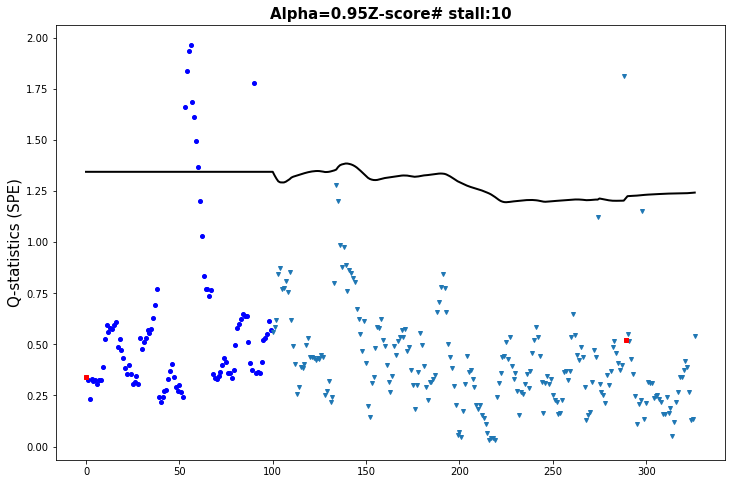

In [13]:
fig = plt.figure(figsize=(12, 8))
x0 = op['IND_x0']
x1 = op['IND_x1']
plt.plot(x0, Q['Qdist'][x0], 'bo', linewidth=2, markersize=4)
plt.plot(x1, Q['Qdist'][x1], 'v', linewidth=2, markersize=4)

alpha = 0.95
SD_type = 'Z-score'
PCA_par = {}
PCA_par['n_stall'] = 10;

IND_abnor = np.argwhere(PC['Updated']==0)
IND_nor = np.argwhere(PC['Updated']==1)
plt.plot(IND_abnor,Q['Qdist'][IND_abnor],'rs',linewidth=2, markersize=4) # Outlier and faulty samples
plt.plot(IND_nor,Q['distcrit'][IND_nor][:,:, 0],'k-',linewidth=2, markersize=4) # Outlier and faulty samples
plt.ylabel('Q-statistics (SPE)',fontsize=15)
plt.title('Alpha='+str(alpha)+str(SD_type)+'# stall:'+str(PCA_par['n_stall']),fontsize=15,fontweight='bold')
# plt.legend(fontsize='x-large')
plt.show